## Dataset Lenght of Stay

Il dataset che abbiamo scelto per il nostro task contiene 100.000 records ognuno dei quali è relativo al ricovero ospedaliero di un paziente.
Gli attributi considerati sono in parte relativi all'identità del paziente, e in parte alla sua condizione clinica e sanitaria. 

È interessante osservare la distribuzione dei diversi attributi.
Un fatto immediatamente evidente è lo sbilanciamento delle etichette di classe: la maggior parte delle durate di ricovero sono inferiori alla metà del valore massimo.

In [48]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split   #funzioni per dividere il dataset in test/validation/training set
import datetime #fornisce funzioni e classi per lavorare con date e tempi
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator #strumento di visualizzazione per l’esplorazione dei dati
from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook
import base64 #fornisce funzioni per codificare e decodificare dati binari in stringhe ASCII utilizzando la codifica base64
pd.set_option('future.no_silent_downcasting', True)     # Consente che si possa cambiare il tipo degli attributi nel dataset, servirà in fase di preprocessing


C:\Users\gobba\AppData\Local\Temp\ipykernel_22008\788373187.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML #funzioni utilizzate per visualizzare output HTML nel notebook


Importando il dataset e visualizzando i primi record ci accorgiamo che ci sono degli attributi data, questi non possono essere elaborati direttamente da Tensorflow ma vanno preprocessati e convertiti in valori numerici.
Assegnamo ad ogni data il corrispondente giorno dell'anno da 1 a 365 (o 366 se l'anno e bisestile)

In [49]:
df = pd.read_csv("LengthOfStay.csv") #carica il dataframe in una variabile struttando pandas

Sistemate le date, gli altri attributi a cui dovremo dare una codifica numerica sono:
- rcount: trasformeremo il valore 5+ in 5
- gender: trasformeremo M in 0 ed F 1
- facid: trasformeremo le lettere in numeri incrementali


In [50]:
test_ratio = 0.15
val_ratio = 0.15
data_len = len(df)

train_bound = int(data_len*(1-val_ratio-test_ratio))
val_bound = int(data_len*(1-test_ratio))

df_features = df.iloc[:, 1:-1]
df_labels = df.iloc[:, -1]

x_train, y_train = df_features[:train_bound], df_labels[:train_bound]

In [51]:
fsg = FeatureStatisticsGenerator() #Crea un oggetto FeatureStatisticsGenerator, che è una classe di Facets che genera statistiche dai tuoi dati
dataframes = [ {'table': pd.concat([x_train, y_train], axis=1), 'name': 'trainData'}] #Crea un dizionario con dentro il dataframe
censusProto = fsg.ProtoFromDataFrames(dataframes) # Genera le statistiche dal DataFrame
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8") # codifica dei dati del dataset

# Impostazioni per la visualizzazione (mostra degli attributi evidentemente sbilanciati)
HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script> <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html"> <facets-overview id="elem"></facets-overview> <script> document.querySelector("#elem").protoInput = "{protostr}"; </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

c:\Users\gobba\miniconda3\envs\kambinete\lib\site-packages\facets_overview\base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


A questo punto il dataset ha solamente valori numerici e può essere trattato come un tensore.
Sappiamo che le reti neurali necessitano che i tensori da esse elaborati contengano valori tra 0 e 1, dunque è opportuno standardizzare i dati

In [52]:
dates = df["vdate"]     # Date originali
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates] # Date codificate 
encoding_dict = dict(zip(dates, encoded_dates))     # Creazione dizionario di codifica per le date
df.replace({"vdate": encoding_dict}, inplace=True)  # Sostituzione nella colonna

dates = df["discharged"]
encoded_dates = [datetime.datetime.strptime(str(date), "%m/%d/%Y").timetuple().tm_yday for date in dates]
encoding_dict = dict(zip(dates, encoded_dates))
df.replace({"discharged": encoding_dict}, inplace=True)

df.replace({"rcount": dict(zip(sorted(df["rcount"].unique()), range(6)))}, inplace=True)   # Codifica del 5+ in 5 e conversione a interi

df.replace({"gender": "M"}, 0, inplace=True)    # Codifica binaria del genere, assegna 0 a maschio e 1 a femmina
df.replace({"gender": "F"}, 1, inplace=True)

keys = df["facid"].unique()                        # Estrazione dei valori unici dell'attributo
ints = {key: value for value, key in enumerate(keys)}    # Creazione del dizionario di codifica

df.replace({"facid": ints}, inplace=True)                # Codifica del facid

In [53]:
dataset = df.to_numpy() #Converte il dataframe in un array numpy

#divide le colonne del dataset in attributi e label
features = dataset[:, 1:-1]
labels = dataset[:, -1]

#funzione che standardizza i dati nel range [0,1] e li rende di tipo float32
def standardize(dataset: np.ndarray) -> tf.Tensor:
    for i in range(dataset.shape[1]):
        column = dataset[:, i]
        dataset[:, i] = (column - np.min(column)) / (np.max(column) - np.min(column))
    return tf.convert_to_tensor(dataset, dtype=tf.float32)

features = standardize(features) #standardizza i dati nel range [0,1]

#divide i dati in dati in train, validazione e test set
x_train, y_train = features[:train_bound], labels[:train_bound]
x_val, y_val = features[train_bound:val_bound], features[train_bound:val_bound]
x_test, y_test = features[val_bound:], labels[val_bound:]

print(tf.shape(x_train), tf.shape(x_val), tf.shape(x_test)) #stampa le dimensini dei nuovi dataset creati


tf.Tensor([70000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32) tf.Tensor([15000    26], shape=(2,), dtype=int32)


In [54]:
import tensorflow as tf
from tfkan.layers import DenseKAN
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


In [55]:

tf.random.set_seed(420)

class RootMeanSquaredError(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RootMeanSquaredError, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError(name='mse')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        return tf.sqrt(self.mse.result())
        
    def reset_states(self):
        self.mse.reset_states()


# Lista di metrics necessarie per valutare le performance.
METRICS = [
  tf.keras.metrics.MeanSquaredError(name='mse'),
  tf.keras.metrics.MeanAbsoluteError(name='mae'),
  tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

# Parametri gestibili da interfaccia
HIDDEN_UNITS_LAYER_01 = 8 #@param
HIDDEN_UNITS_LAYER_02 = 1 #@param
LEARNING_RATE = 0.01 #@param
EPOCH = 50 #@param


# Creazione del modello KAN
kan = tf.keras.models.Sequential([
    DenseKAN(HIDDEN_UNITS_LAYER_01),
    DenseKAN(HIDDEN_UNITS_LAYER_02)
])
kan.build(input_shape=(None, 26))
kan.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan_8 (DenseKAN)          │ (None, 8)              │         1,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_9 (DenseKAN)          │ (None, 1)              │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,953 (7.63 KB)

 Trainable params: 1,953 (7.63 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

tf.random.set_seed(420)

def rmse(y_true, y_pred):
    return tf.sqrt(tf.keras.losses.MSE(y_true, y_pred))

kan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss='mse', metrics=[rmse, 'mae'])

kan_history = kan.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)


Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.4032 - mae: 1.8946 - rmse: 1.8946 - val_loss: 1.2302 - val_mae: 0.8578 - val_rmse: 0.8578
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1331 - mae: 0.8049 - rmse: 0.8049 - val_loss: 0.7699 - val_mae: 0.6208 - val_rmse: 0.6208
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7476 - mae: 0.6140 - rmse: 0.6140 - val_loss: 0.6592 - val_mae: 0.5680 - val_rmse: 0.5680
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6646 - mae: 0.5745 - rmse: 0.5745 - val_loss: 0.6173 - val_mae: 0.5488 - val_rmse: 0.5488
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6296 - mae: 0.5580 - rmse: 0.5580 - val_loss: 0.5973 - val_mae: 0.5392 - val_rmse: 0.5392
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6107 - mae: 0.5485 - rmse: 0.5485 - val_loss: 0.5855 - val_mae: 0.5330 - val_rmse: 0.5330
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5984 - mae: 0.5423 - rmse:

In [ ]:
# MLP
mlp = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
mlp.build(input_shape=(None, 26))
mlp.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,793 (7.00 KB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=[rmse, 'mae'])

mlp_history = mlp.fit(x_train, y_train, epochs=EPOCH, batch_size=128, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 2.6243 - mae: 1.1724 - rmse: 1.1724 - val_loss: 1.1888 - val_mae: 0.8284 - val_rmse: 0.8284
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 1.1786 - mae: 0.8283 - rmse: 0.8283 - val_loss: 1.1071 - val_mae: 0.8087 - val_rmse: 0.8087
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 1.0842 - mae: 0.7893 - rmse: 0.7893 - val_loss: 1.0330 - val_mae: 0.7651 - val_rmse: 0.7651
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 1.0157 - mae: 0.7548 - rmse: 0.7548 - val_loss: 0.9726 - val_mae: 0.7244 - val_rmse: 0.7244
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 0.9463 - mae: 0.7176 - rmse: 0.7176 - val_loss: 0.9037 - val_mae: 0.6788 - val_rmse: 0.6788
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.8852 - mae: 0.6850 - rmse: 0.6850 - val_loss: 0.8401 - val_mae: 0.6436 - val_rmse: 0.6436
Epoch 7/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.8229 - mae: 

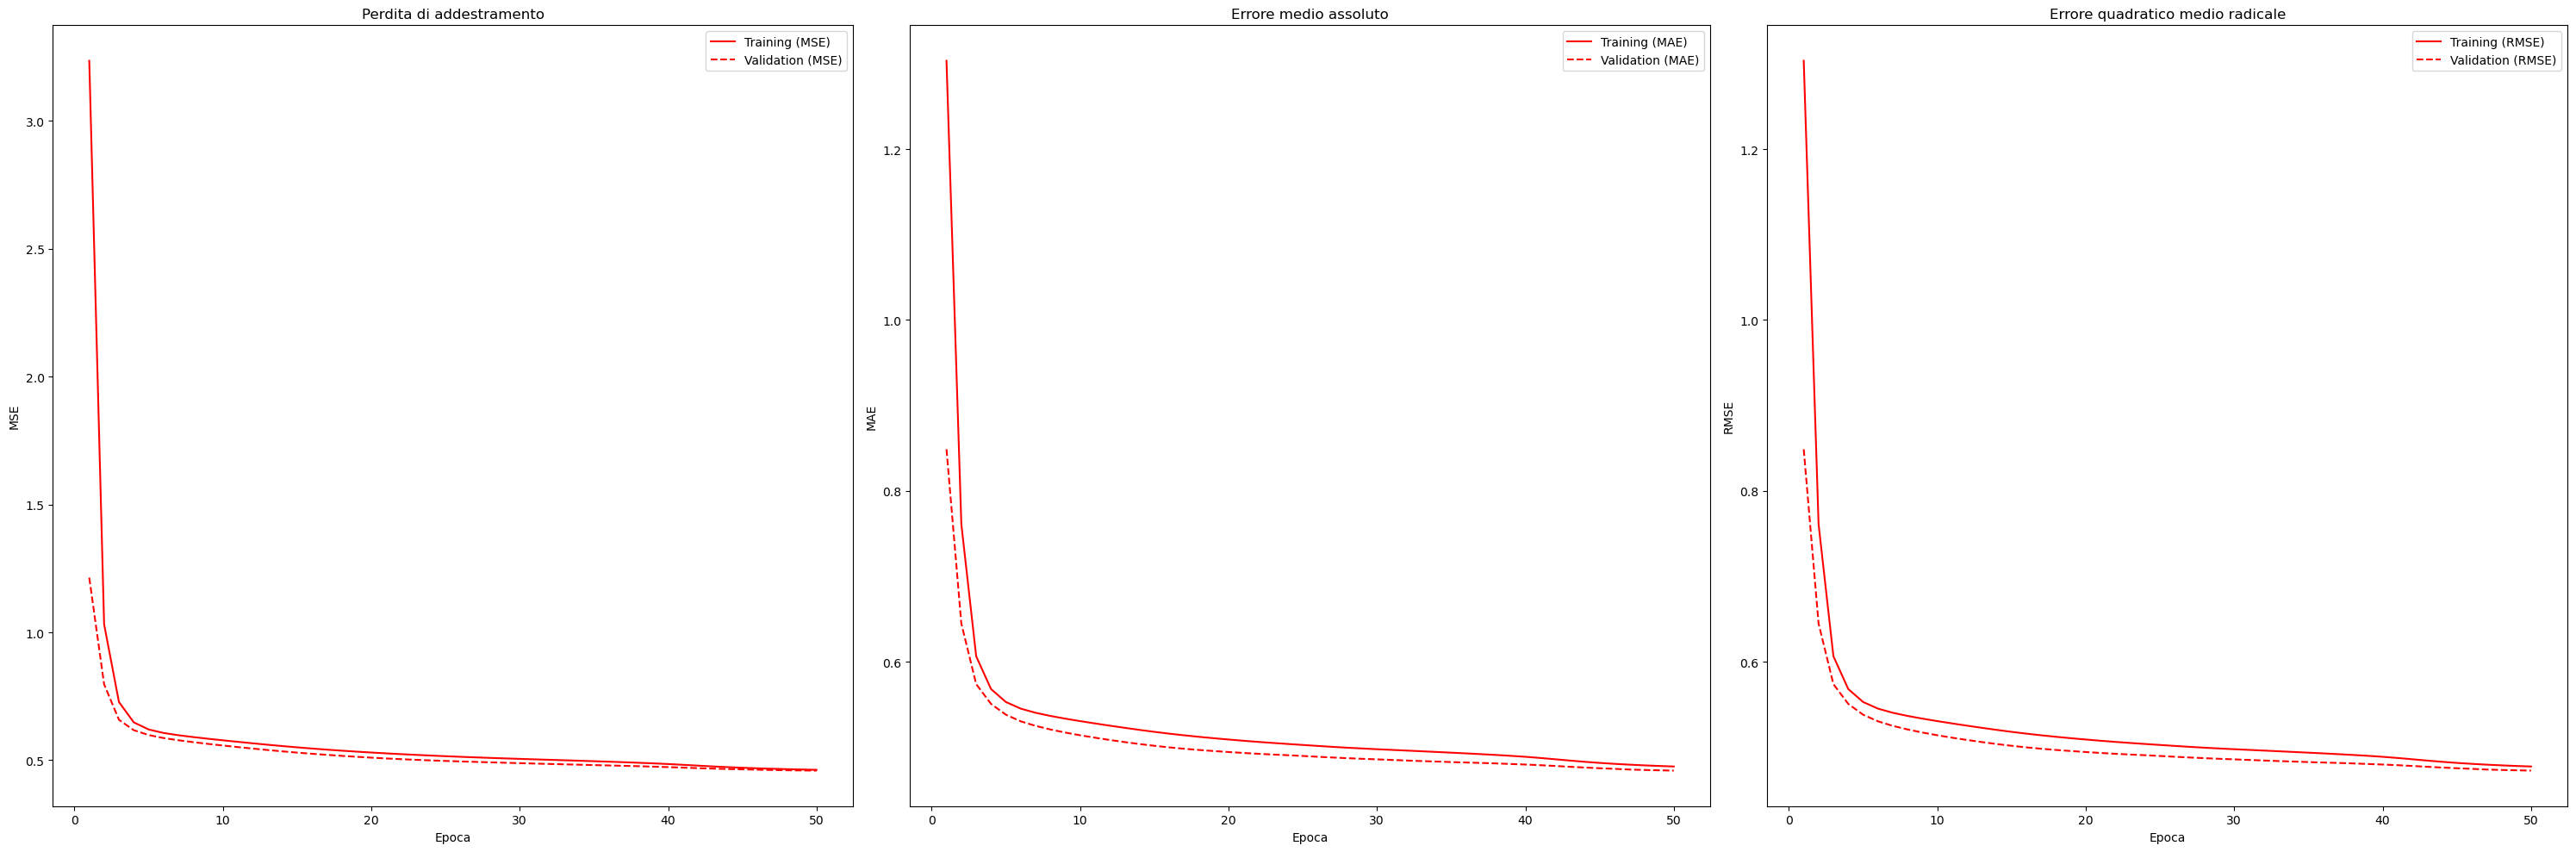

In [ ]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' sia il risultato del tuo modello.fit()
loss = kan_history.history['loss']
val_loss = kan_history.history['val_loss']
mae = kan_history.history['mae']
val_mae = kan_history.history['val_mae']
rmse = kan_history.history['rmse']
val_rmse = kan_history.history['val_rmse']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'r', label='Training (MSE)') # linea rossa per training
plt.plot(epochs, val_loss, 'r--', label='Validation (MSE)') # linea tratteggiata rossa per validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, mae, 'r', label='Training (MAE)') # linea rossa per training
plt.plot(epochs, val_mae, 'r--', label='Validation (MAE)') # linea tratteggiata rossa per validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, rmse, 'r', label='Training (RMSE)') # linea rossa per training
plt.plot(epochs, val_rmse, 'r--', label='Validation (RMSE)') # linea tratteggiata rossa per validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


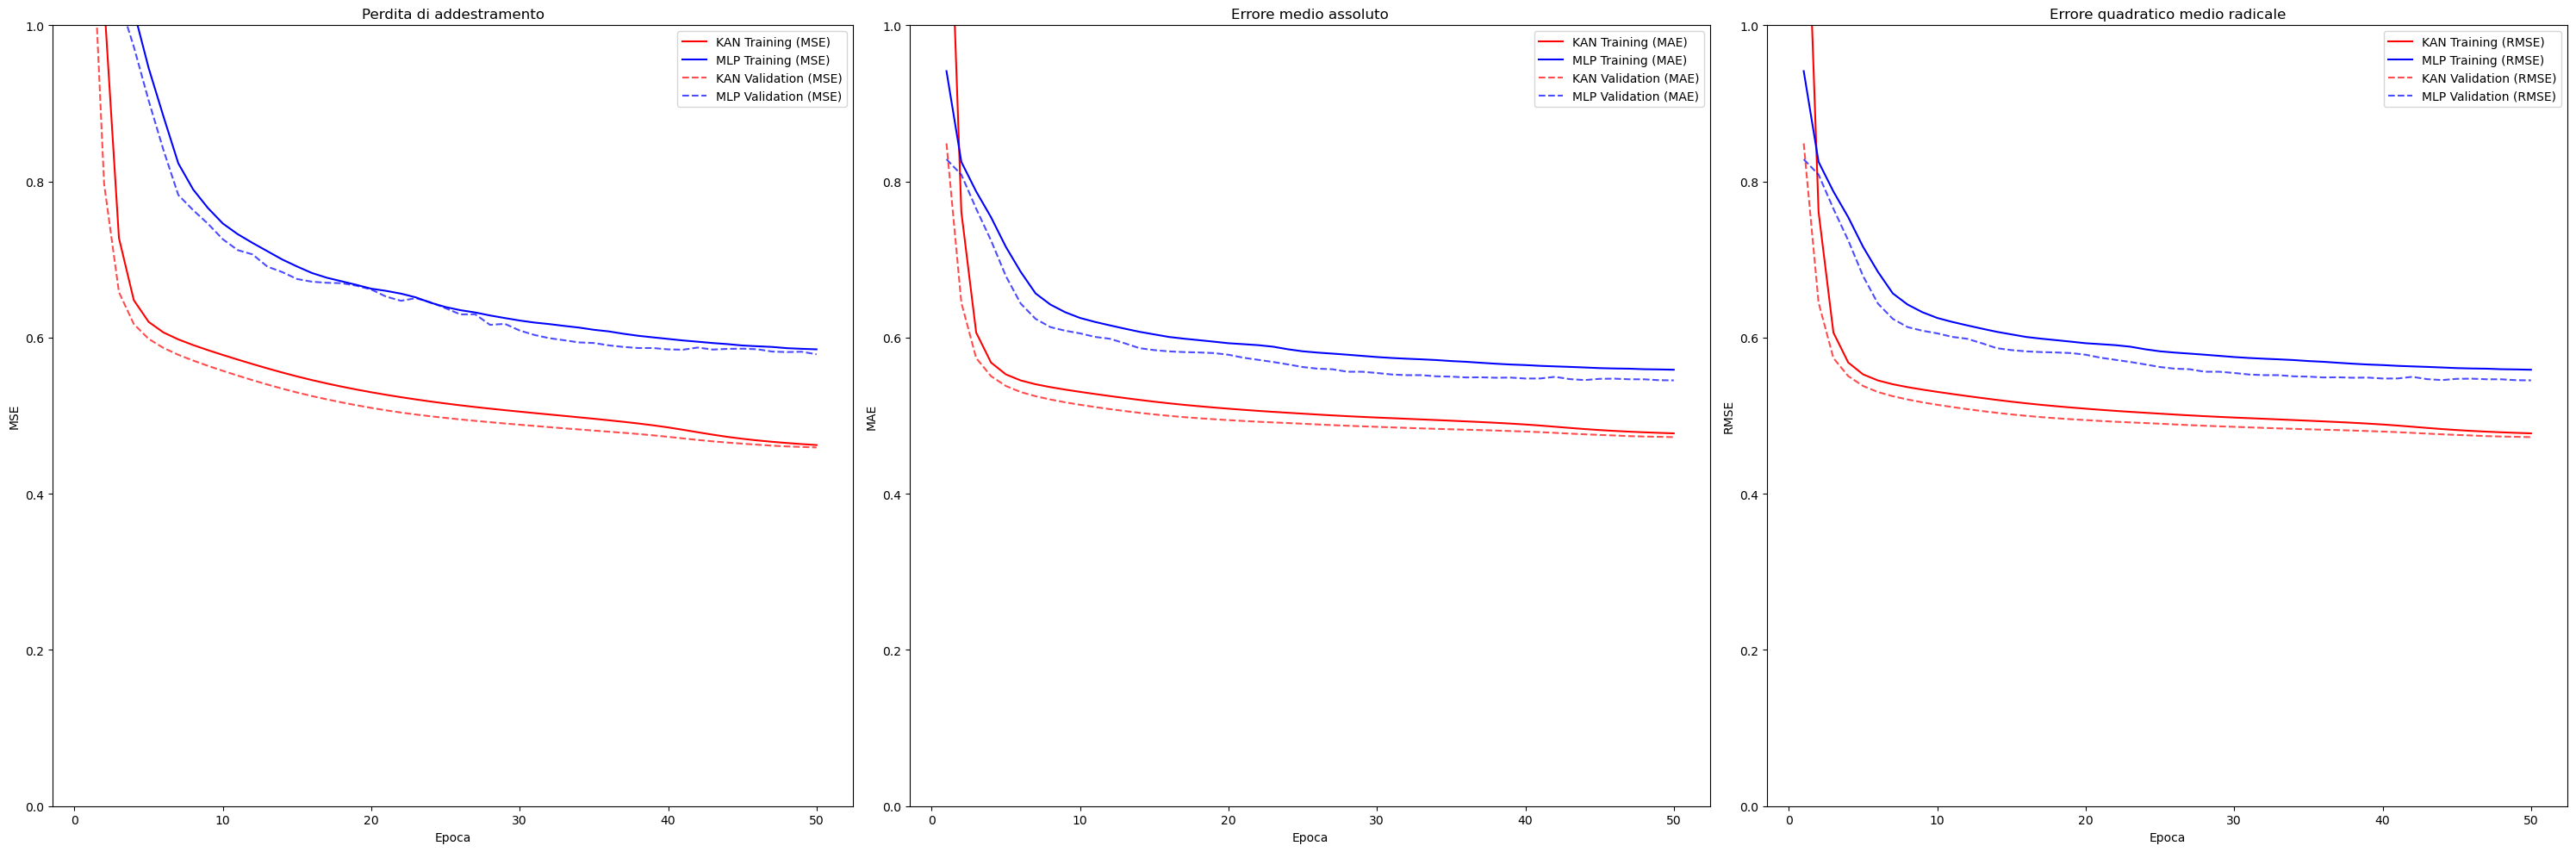

In [37]:
import matplotlib.pyplot as plt

# Supponiamo che 'kan_history' e 'mlp_history' siano i risultati del tuo modello.fit()
kan_loss = kan_history.history['loss']
kan_val_loss = kan_history.history['val_loss']
kan_mae = kan_history.history['mae']
kan_val_mae = kan_history.history['val_mae']
kan_rmse = kan_history.history['rmse']
kan_val_rmse = kan_history.history['val_rmse']

mlp_loss = mlp_history.history['loss']
mlp_val_loss = mlp_history.history['val_loss']
mlp_mae = mlp_history.history['mae']
mlp_val_mae = mlp_history.history['val_mae']
mlp_rmse = mlp_history.history['rmse']
mlp_val_rmse = mlp_history.history['val_rmse']

epochs = range(1, len(kan_loss) + 1)

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
plt.plot(epochs, kan_loss, 'r', label='KAN Training (MSE)') # linea rossa per KAN
plt.plot(epochs, mlp_loss, 'b', label='MLP Training (MSE)') # linea blu per MLP
plt.plot(epochs, kan_val_loss, 'r--', alpha=0.7, label='KAN Validation (MSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_loss, 'b--', alpha=0.7, label='MLP Validation (MSE)') # linea tratteggiata blu per MLP validation
plt.title('Perdita di addestramento')
plt.xlabel('Epoca')
plt.ylabel('MSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, kan_mae, 'r', label='KAN Training (MAE)') # linea rossa per KAN
plt.plot(epochs, mlp_mae, 'b', label='MLP Training (MAE)') # linea blu per MLP
plt.plot(epochs, kan_val_mae, 'r--', alpha=0.7, label='KAN Validation (MAE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_mae, 'b--', alpha=0.7, label='MLP Validation (MAE)') # linea tratteggiata blu per MLP validation
plt.title('Errore medio assoluto')
plt.xlabel('Epoca')
plt.ylabel('MAE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, kan_rmse, 'r', label='KAN Training (RMSE)') # linea rossa per KAN
plt.plot(epochs, mlp_rmse, 'b', label='MLP Training (RMSE)') # linea blu per MLP
plt.plot(epochs, kan_val_rmse, 'r--', alpha=0.7, label='KAN Validation (RMSE)') # linea tratteggiata rossa per KAN validation
plt.plot(epochs, mlp_val_rmse, 'b--', alpha=0.7, label='MLP Validation (RMSE)') # linea tratteggiata blu per MLP validation
plt.title('Errore quadratico medio radicale')
plt.xlabel('Epoca')
plt.ylabel('RMSE')
plt.ylim([0, 1])  # Imposta il range dell'asse y
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = kan.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    results[sg] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step
                                                   0  \
MSE                                           0.5136   
MAE                                           0.4959   
RMSE  tf.Tensor(0.71663535, shape=(), dtype=float32)   

                                                   1  
MSE                                           0.4163  
MAE                                           0.4541  
RMSE  tf.Tensor(0.64518094, shape=(), dtype=float32)  


In [39]:
# Definizione delle categorie e sottogruppi
CATEGORY = 2  # indice dell'attributo "gender" nel tuo dataset
SUBGROUPS = [0, 1]  # 0 per maschio, 1 per femmina

# Creazione di un dizionario per memorizzare i risultati
mlp_results = {}

for sg in SUBGROUPS: #per ogni gruppo nell'elenco dei sottogruppi
    
    # Filtraggio del dataset di test per il sottogruppo corrente
    subgroup_indices = x_test[:, CATEGORY] == sg
    features = x_test[subgroup_indices]
    labels = y_test[subgroup_indices]
    
    # Calcolo delle previsioni del modello sul sottogruppo corrente
    predictions = mlp.predict(features)
    
    # Calcolo delle metriche personalizzate per ciascun sottogruppo
    mse_value = tf.keras.metrics.MeanSquaredError()(labels, predictions).numpy()
    mae_value = tf.keras.metrics.MeanAbsoluteError()(labels, predictions).numpy()
    rmse_value = tf.sqrt(mse_value)
    
    # Memorizzazione dei risultati
    mlp_results['Maschio' if sg == 0 else 'Femmina'] = [mse_value, mae_value, rmse_value]

# Creazione di un DataFrame per visualizzare le metriche di performance
mlp_performance_df = pd.DataFrame(mlp_results, index=['MSE', 'MAE', 'RMSE'])
pd.options.display.float_format = '{:,.4f}'.format  # Formattazione float per il DataFrame

# Stampa delle metriche di performance
print(mlp_performance_df)


208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
                                            Maschio  \
MSE                                          0.6407   
MAE                                          0.5728   
RMSE  tf.Tensor(0.8004379, shape=(), dtype=float32)   

                                             Femmina  
MSE                                           0.5294  
MAE                                           0.5234  
RMSE  tf.Tensor(0.72758746, shape=(), dtype=float32)  


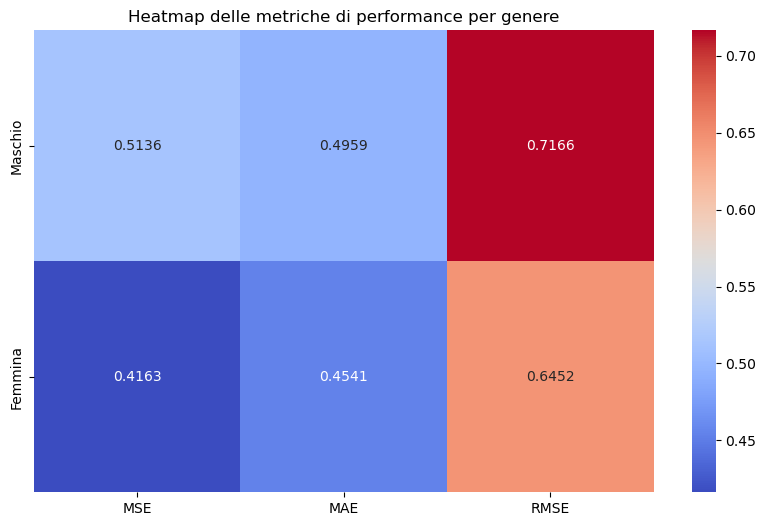

In [40]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance
performance_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
performance_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
performance_df = performance_df.astype(float)

# Trasposizione del DataFrame per avere le metriche come colonne e i valori di genere come righe
performance_df = performance_df.transpose()

# Creazione della heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Heatmap delle metriche di performance per genere')
plt.show()


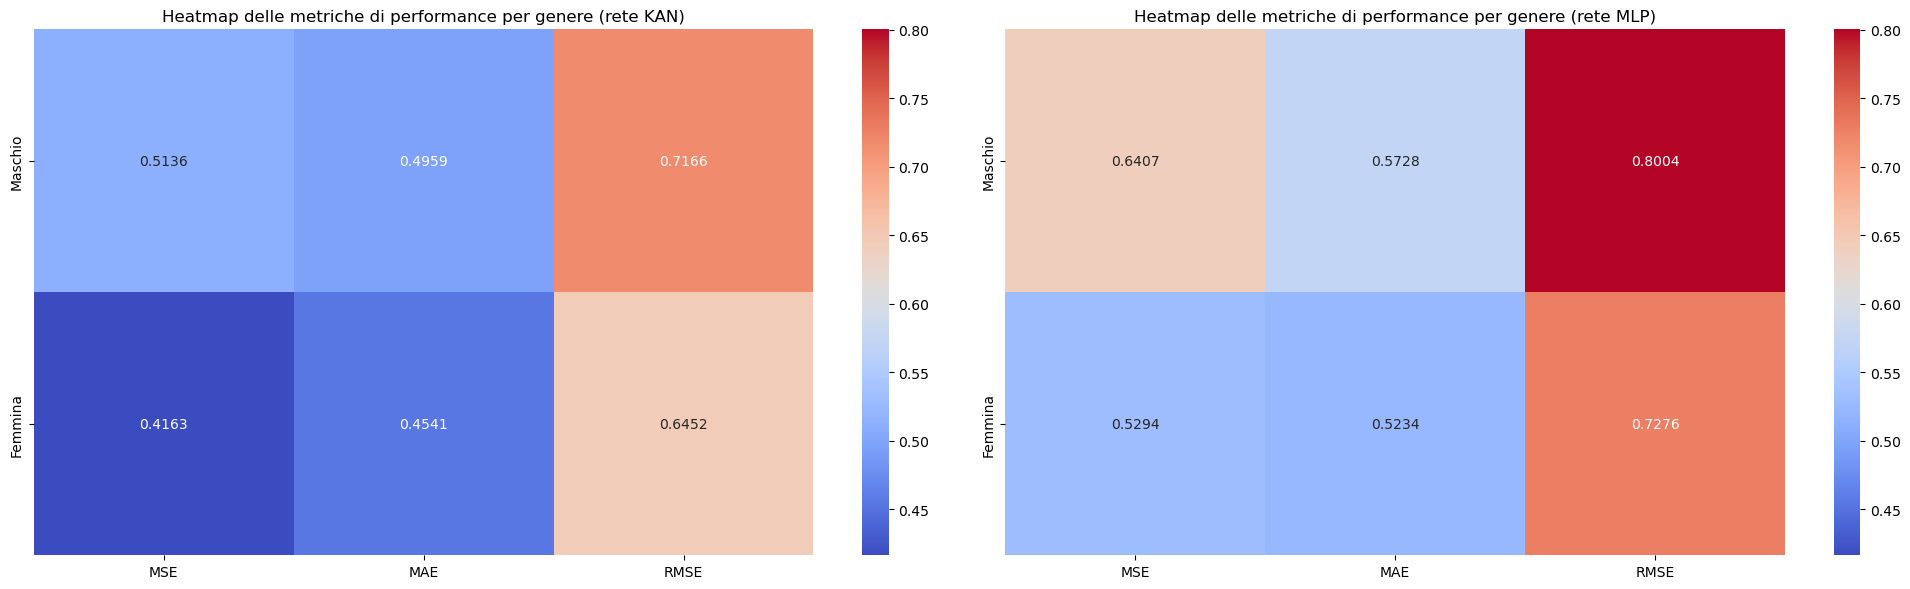

In [41]:
import seaborn as sns
import pandas as pd

# Creazione di un DataFrame per visualizzare le metriche di performance della rete KAN
kan_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE'])
kan_df.columns = ['Maschio', 'Femmina']

# Conversione dei dati in float
kan_df = kan_df.astype(float)
mlp_performance_df = mlp_performance_df.astype(float)

# Trasposizione dei DataFrame per avere le metriche come colonne e i valori di genere come righe
kan_df = kan_df.transpose()
mlp_performance_df = mlp_performance_df.transpose()

# Calcolo dei valori minimi e massimi per la scala di colori
vmin = min(kan_df.min().min(), mlp_performance_df.min().min())
vmax = max(kan_df.max().max(), mlp_performance_df.max().max())

# Creazione delle heatmap
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.heatmap(kan_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete KAN)')

plt.subplot(1, 2, 2)
sns.heatmap(mlp_performance_df, annot=True, cmap='coolwarm', fmt=".4f", vmin=vmin, vmax=vmax)
plt.title('Heatmap delle metriche di performance per genere (rete MLP)')

plt.tight_layout()
plt.show()


In [43]:
# Lista delle caratteristiche
from sklearn.inspection import permutation_importance

features = ['vdate', 'rcount', 'gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'discharged', 'facid']

def calculate_feature_importance(model, x_val, y_val):
    # Calcola l'importanza delle caratteristiche
    results = permutation_importance(model, x_val, y_val, scoring='neg_mean_squared_error')
    # Ottieni l'importanza delle caratteristiche
    importance = results.importances_mean
    # Crea un dizionario con le caratteristiche e la loro importanza
    feature_importance = dict(zip(features, importance))
    return feature_importance

# Calcola l'importanza delle caratteristiche per i modelli
mlp_importance = calculate_feature_importance(mlp, x_test, y_test)
kan_importance = calculate_feature_importance(kan, x_test, y_test)


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
469/469 ━━━

In [44]:
print("Importanza delle caratteristiche per il modello MLP:")
for feature, importance in mlp_importance.items():
    print(f"Caratteristica: {feature}, Importanza: {importance}")

print("\nImportanza delle caratteristiche per il modello KAN:")
for feature, importance in kan_importance.items():
    print(f"Caratteristica: {feature}, Importanza: {importance}")

Importanza delle caratteristiche per il modello MLP:
Caratteristica: vdate, Importanza: 0.9424144864082337
Caratteristica: rcount, Importanza: 6.536324536800384
Caratteristica: gender, Importanza: 0.0009624958038330078
Caratteristica: dialysisrenalendstage, Importanza: 0.09989889860153198
Caratteristica: asthma, Importanza: 0.11906075477600098
Caratteristica: irondef, Importanza: 0.23209097385406494
Caratteristica: pneum, Importanza: 0.11878887414932252
Caratteristica: substancedependence, Importanza: 0.14531861543655394
Caratteristica: psychologicaldisordermajor, Importanza: 0.7349921584129333
Caratteristica: depress, Importanza: 0.08600888252258301
Caratteristica: psychother, Importanza: 0.11625717878341675
Caratteristica: fibrosisandother, Importanza: 0.051157689094543456
Caratteristica: malnutrition, Importanza: 0.10124908685684204
Caratteristica: hemo, Importanza: 0.2122402787208557
Caratteristica: hematocrit, Importanza: 0.2105066180229187
Caratteristica: neutrophils, Importanza:

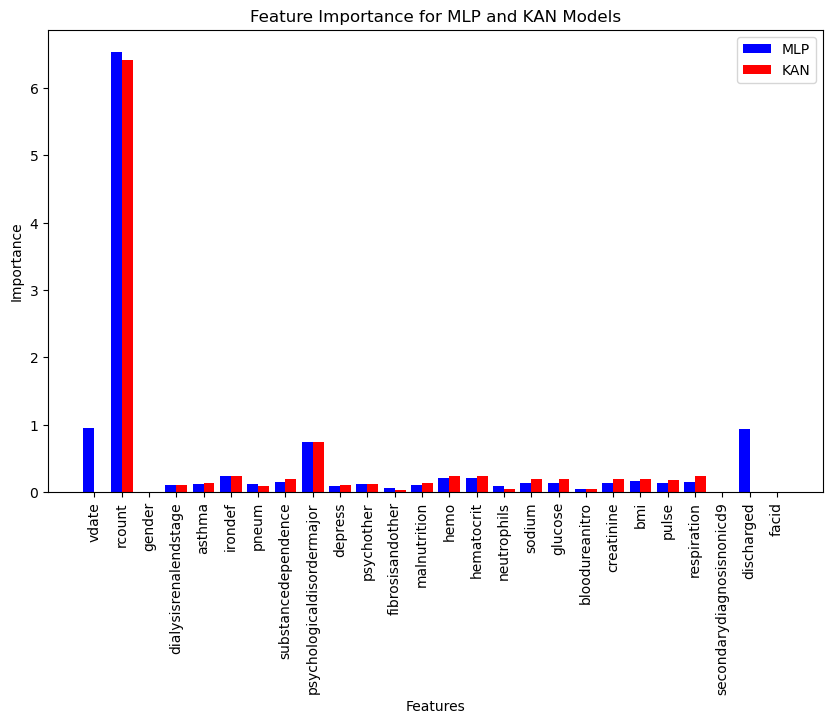

In [45]:

# Crea le etichette per l'asse x
x = np.arange(len(mlp_importance))

# Crea un grafico a barre con dimensioni personalizzate
fig, ax = plt.subplots(figsize=(10, 6))  # Modifica le dimensioni qui

# Crea le barre per l'importanza delle caratteristiche del modello MLP
bar1 = ax.bar(x - 0.2, list(mlp_importance.values()), 0.4, label='MLP', color='blue')

# Crea le barre per l'importanza delle caratteristiche del modello KAN
bar2 = ax.bar(x + 0.2, list(kan_importance.values()), 0.4, label='KAN', color='red')

# Aggiungi le etichette, il titolo e la legenda
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance for MLP and KAN Models')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=90)
ax.legend()

# Mostra il grafico
plt.show()

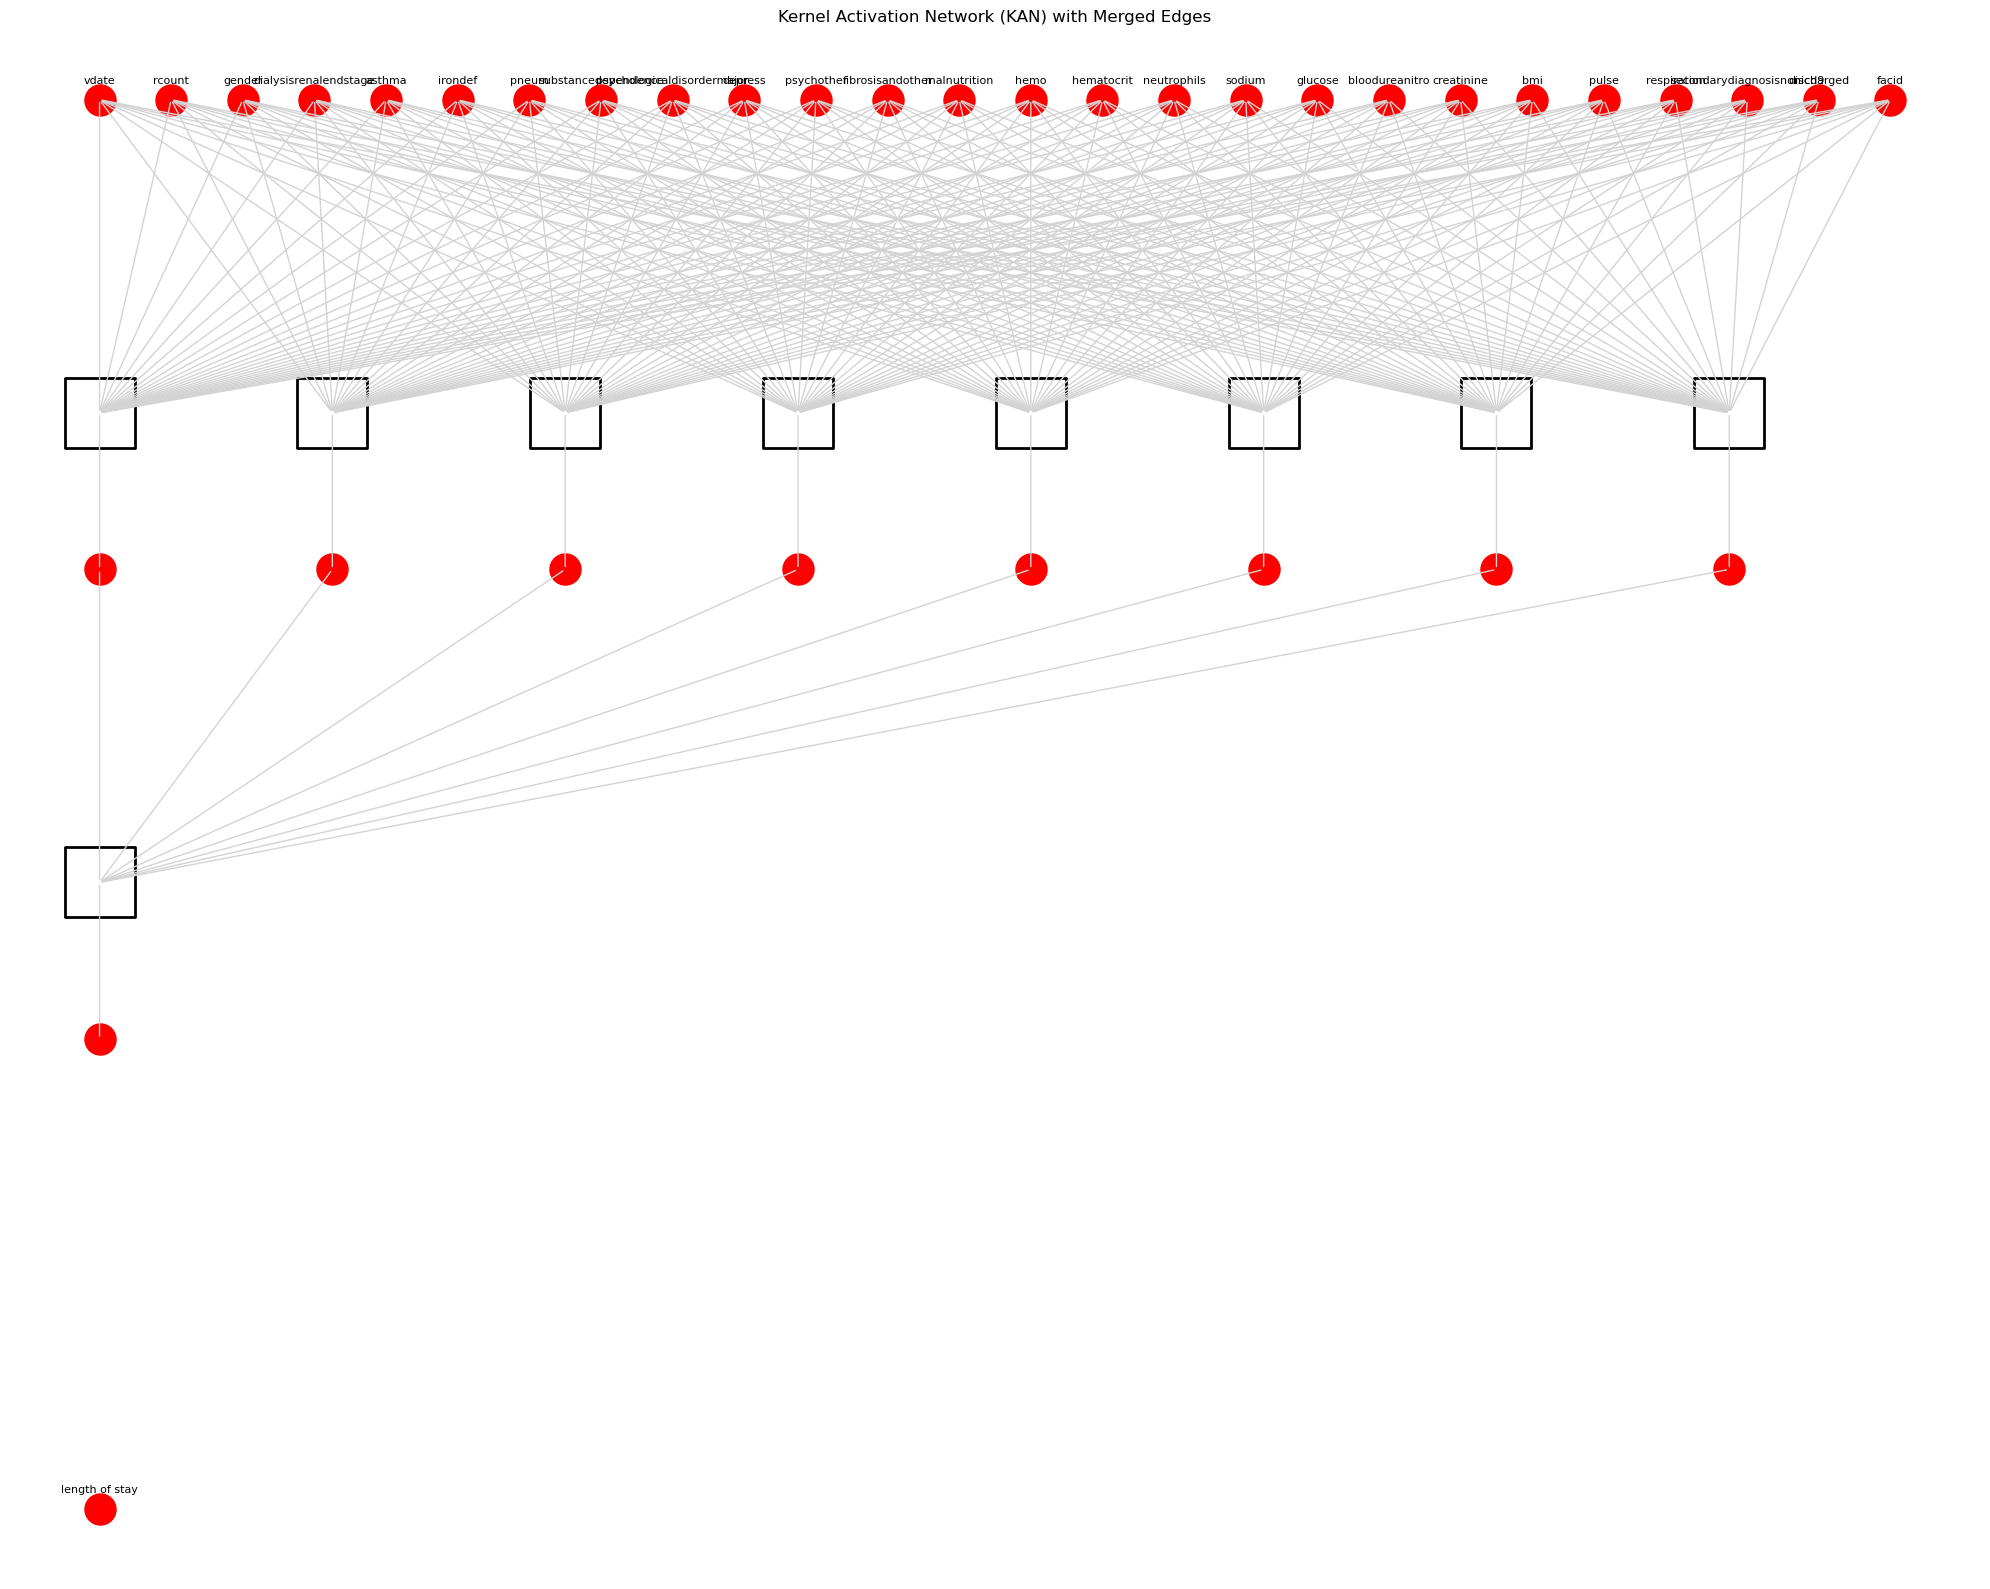

In [47]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def create_kan_tree_from_model(model, features):
    G = nx.DiGraph()
    scale_x = 2  # Increase horizontal distance
    
    # Add input nodes
    for i, feature in enumerate(features):
        G.add_node(feature, layer=0, pos=(i * scale_x, 0))
    
    # Add hidden layers and output layer from model
    total_layers = len(model.layers)
    for layer_idx, layer in enumerate(model.layers):
        units = layer.units
        for j in range(units):
            G.add_node(f"h{layer_idx+1}_{j}", layer=layer_idx+1, pos=(j * len(features) / units * scale_x, -(layer_idx+1) / (total_layers+1)))
        
        # Connect to previous layer
        if layer_idx == 0:
            prev_layer_units = len(features)
        else:
            prev_layer_units = model.layers[layer_idx-1].units
        
        for i in range(prev_layer_units):
            for j in range(units):
                if layer_idx == 0:
                    G.add_edge(features[i], f"h{layer_idx+1}_{j}")
                else:
                    G.add_edge(f"h{layer_idx}_{i}", f"h{layer_idx+1}_{j}")
    
    # Add output node
    G.add_node("length of stay", layer=len(model.layers)+1, pos=(0 * scale_x, -(len(model.layers)+1) / (total_layers+1)))
    
    # Connect last hidden layer to output
    last_hidden_units = model.layers[-1].units
    for i in range(last_hidden_units):
        G.add_edge(f"h{len(model.layers)}_{i}", "length of stay")
    
    return G



def draw_merged_edges(G, pos, ax, edge_color='lightgray'):
    merge_points = []
    for target in G.nodes():
        in_edges = G.in_edges(target)
        if len(in_edges) > 1:
            target_pos = np.array(pos[target])
            merge_point = target_pos + np.array([0, (pos[list(in_edges)[0][0]][1] - target_pos[1]) / 3])  # A third of the way
            merge_points.append(merge_point)
            
            for source, _ in in_edges:
                start = np.array(pos[source])
                
                # Draw edge from source to merge_point
                ax.annotate("", xy=merge_point, xytext=start,
                            arrowprops=dict(arrowstyle="-", color=edge_color, connectionstyle="arc3,rad=0.0"))
            
            # Draw single edge from merge_point to target
            ax.annotate("", xy=target_pos, xytext=merge_point,
                        arrowprops=dict(arrowstyle="-", color=edge_color))
    
    # Draw squares at merge points
# Draw squares at merge points
    for point in merge_points:
        ax.scatter(*point, s=2500, marker='s',  color='white', edgecolor='black', linewidth=2)



model = kan

# Create the graph from the model
G = create_kan_tree_from_model(model, features)

# Set up the plot
fig, ax = plt.subplots(figsize=(20, 16))
pos = nx.get_node_attributes(G, 'pos')


draw_merged_edges(G, pos, ax)


# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='red', ax=ax)

# Draw merged edges without splines

# Add labels
label_pos = {node: (x, y + 1/72) for node, (x, y) in pos.items()}
labels = {node: node if G.nodes[node]['layer'] == 0 or node == "length of stay" else "" for node in G.nodes()}
nx.draw_networkx_labels(G, label_pos, labels, font_size=8, ax=ax)

plt.title("Kernel Activation Network (KAN) with Merged Edges")
plt.axis('off')
plt.tight_layout()
plt.show()